# Credit Card Fraud Project

### Description

The aim of this project is to simulate a credit card fraud detection algorithm as close to production-quality as possible. Below you can find the project's outline:

### Outline

1. Establishing the problem

2. Investigating the dataset
    1. EDA
    2. Feature importance

3. Setting baseline results
    1. Logistic Regression
    2. Random Forest

4. Base neural network
    1. Construction
    2. Evaluation (loss, accuracy)

5. Hyperparameter Tuning
    1. Layers
    2. Learning rate & optimization
    3. Dropout rate
    4. Batch size

6. Tracking and comparison

7. Future implementations
    1. Latency improvement (TensorRT, ONNX)
    2. Deploying considerations
    3. Security

8. Real data usefulness
    1. Flask implementation

### Establishing the problem

Security.org reports that an estimated 134 million Americans have been a victim of credit card fraud. Additionally, they estimate that 62 million Americans have experienced it in the past year alone. Unfortunately, this problem is getting increasingly worse. The complexity of the situation and the constant malicious attacks that come with it mean that developing a solution is not only extremely difficult, but also needs to be adaptive to ever changing consumer habits. The goal of this project is to simulate the implementation of a (close-to) production-grade machine learning credit card fraud detection program.

### Investigating the dataset

For this machine learning project, I will be using the a fraud dataset dveloped by CiferAI, available on huggingface:

https://huggingface.co/datasets/CiferAI/Cifer-Fraud-Detection-Dataset-AF?utm_source=chatgpt.com

I chose this dataset for a few reasons: the data is completely synthetic and therefore anonymous, the dataset that it is based off of is widely used and available for comparison, but primarily I chose it because it is massive (20 million rows) and will provide a great basis to train what is supposed to be a highly accurate model.

In [76]:
import pandas as pd
import sklearn
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [34]:
data = pd.read_csv("~/Downloads/Cifer-Fraud-Detection-Dataset-AF-part-1-14.csv")
data2 = data.drop(['type', 'nameOrig', 'nameDest'], axis=1)

In [ ]:
print(data2['isFraud'].value_counts())

isFraud
0    1498016
1       1984
Name: count, dtype: int64


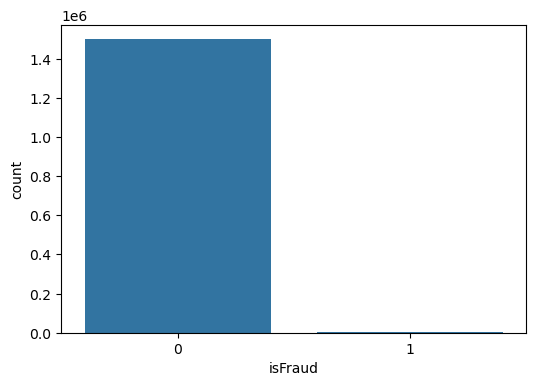

In [ ]:
plt.figure(figsize=((6,4)))
seaborn.countplot(x='isFraud', data=data2)
plt.show()

The data here is extremely imbalanced, so some tweaking will need to be done in order to make sure that the model can actually identify fraudulent activity.

### Setting Baseline Results

In [35]:
X = data2.drop(['isFraud','step'], axis=1)
y = data2['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [6]:
#model
model = LogisticRegression(max_iter=1000, random_state=8)

In [7]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,8
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
y_pred = model.predict(X_test)

In [9]:
accuracy_score(y_test, y_pred)

0.9986933333333333

In [10]:
f1_score(y_test, y_pred)

0.0

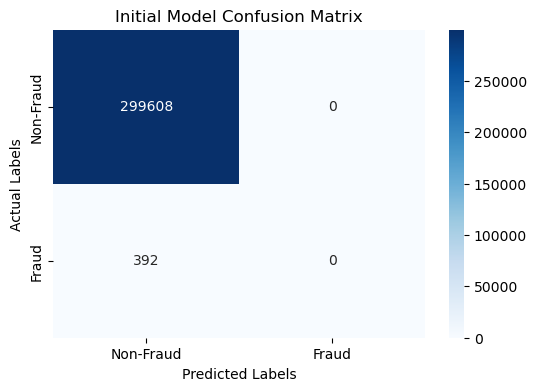

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Initial Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

Without any calibration or adjustment, the model never classifies a single entry as fraud because of the overwhelming unbalance towards normal transactions. One way to tackle this issue is to artifially resample the data so that there are more instances of fraud, hopefully the model has an easier time recognizing it.

In [12]:
ros = RandomOverSampler(random_state=8)

In [13]:
X_resamples, y_resampled = ros.fit_resample(X_train, y_train)

In [15]:
class_count = y_resampled.value_counts()
class_count

isFraud
0    1198408
1    1198408
Name: count, dtype: int64

So now there's an equal number of fraud and non-fraud instances.

In [16]:
model.fit(X_resamples, y_resampled)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,8
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [17]:
y_pred_ros = model.predict(X_test)

In [18]:
accuracy_score(y_test, y_pred_ros)

0.2506366666666667

In [20]:
f1_score(y_test, y_pred_ros)

0.0025290732499478655

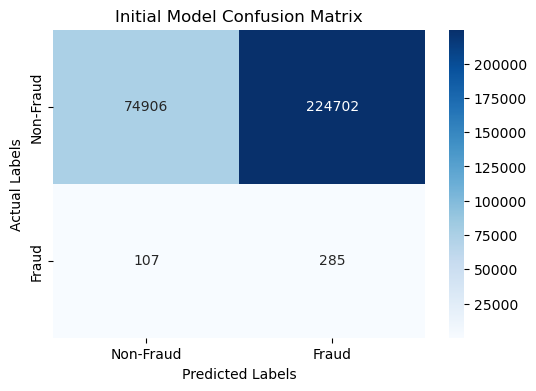

In [19]:
cm = confusion_matrix(y_test, y_pred_ros)
plt.figure(figsize=(6,4))
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Initial Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

Now there is a new problem, the model classifies way to many things as fraud. Another method is needed. I have already tested SMOTE to no success

In [28]:
model = LogisticRegression(max_iter=1000, random_state=8, class_weight='balanced')

In [70]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,8
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [71]:
y_pred = model.predict(X_test)

In [72]:
accuracy_score(y_test, y_pred)

0.8847433333333333

In [73]:
f1_score(y_test, y_pred)

0.0

I think that part of the reason that the model is so bad is because I dropped the type of transaction early on due to it being a character value, it would likely be a little better if I had used numerical reassignment of one-hot encoding. However, I think that logistic regression is just not a great way to classify something like fraud. That being said, next I am going to try decision trees before moving on to training a CNN.

In [36]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,371,CASH_OUT,367336.05,sdv-pii-r8zd6,4514816.83,2108392.86,sdv-pii-q6998,1265486.06,2454140.46,0,0
1,368,TRANSFER,238.63,sdv-pii-xq6z3,430944.71,1865444.60,sdv-pii-n2ql8,107927.46,2021.16,0,0
2,141,CASH_OUT,254.93,sdv-pii-805w0,839593.53,8008353.88,sdv-pii-yo0z6,773352.22,20.79,0,0
3,191,CASH_IN,501547.39,sdv-pii-279tw,41226.40,28633.52,sdv-pii-9zlyl,6825363.55,16442078.24,0,0
4,169,TRANSFER,71832.00,sdv-pii-ksz58,248694.60,793617.86,sdv-pii-0ykbo,579313.76,829850.96,0,0


In [44]:
df['type'].unique()

array(['CASH_OUT', 'TRANSFER', 'CASH_IN', 'PAYMENT', 'DEBIT'],
      dtype=object)

In [47]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

In [49]:
ohetransform = ohe.fit_transform(df[['type']])

In [ ]:
df = data.drop(columns=['nameOrig','nameDest'])

In [64]:
df = pd.concat([df, ohetransform], axis=1)

In [65]:
df = df.drop(columns=['type'])

In [78]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,371,367336.05,4514816.83,2108392.86,1265486.06,2454140.46,0,0,0.0,1.0,0.0,0.0,0.0
1,368,238.63,430944.71,1865444.60,107927.46,2021.16,0,0,0.0,0.0,0.0,0.0,1.0
2,141,254.93,839593.53,8008353.88,773352.22,20.79,0,0,0.0,1.0,0.0,0.0,0.0
3,191,501547.39,41226.40,28633.52,6825363.55,16442078.24,0,0,1.0,0.0,0.0,0.0,0.0
4,169,71832.00,248694.60,793617.86,579313.76,829850.96,0,0,0.0,0.0,0.0,0.0,1.0


In [79]:
X = df.iloc[:,1:13].drop(columns=['isFraud'])
y = df.iloc[:,6]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, test_size=0.2)

In [82]:
rf = RandomForestClassifier()

In [83]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [84]:
y_pred = rf.predict(X_test)

In [85]:
rf.score(X_test, y_test)

0.9986933333333333

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299608
           1       0.00      0.00      0.00       392

    accuracy                           1.00    300000
   macro avg       0.50      0.50      0.50    300000
weighted avg       1.00      1.00      1.00    300000



/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Same problem as before, the fraud is not being predicted at all because of the imbalance in the data.